In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform

# from smoothot.dual_solvers import solve_dual, solve_semi_dual
# There is some changes in source code as compared to the official smoothot.dual_solvers package
# Add in the function of recording history.
from dual_solvers import solve_dual, solve_semi_dual
from smoothot.dual_solvers import NegEntropy, SquaredL2
from smoothot.dual_solvers import get_plan_from_dual, get_plan_from_semi_dual

import ot
# There is some changes as the compared to the official ot package
# modification in the bregman.py file, with "sinkhorn_knopp" function.
import pdb
from pykeops.torch import LazyTensor

import time

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./optimal_transport')
# $tensorboard --logdir='./optimal_transport'

enable_tensorboard = True

In [4]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.DoubleTensor if use_cuda else torch.float64

In [5]:
source = "comunion.jpg"
target = "autumn.jpg"

In [6]:
'''
def load_image(fname) :
    img = io.imread(fname)  # RGB
    #plt.imshow(img)
    #img_tensor = torch.tensor(img)
    #print(img_tensor.size())
    #print(img)
    return img / 255.         # Normalized to [0,1]
'''

def load_image(fname) :
    img = io.imread(fname)  # RGB
    return img

def RGB_cloud(fname, sampling, dtype=torch.float64) :
    A = load_image(fname)
    A = A[::sampling, ::sampling, :]
    #plt.imshow(A)
    RGB_tensor = torch.from_numpy(A).type(dtype).view(-1,3)
    return RGB_tensor

def revert_back_image(RGB_tensor, img_original) :
    return RGB_tensor.view(img_original.size())
    

def get_cost_matrix(c1, c2, p):
    C = torch.zeros([c1.size()[0], c2.size()[0]], dtype = torch.float64)
    for i in range(c1.size()[0]):
        for j in range(c2.size()[0]):
            C[i, j] = torch.norm(c1[i] - c2[j], p)
    return torch.tensor(C)


In [7]:
# Reference from:
# https://www.kernel-operations.io/keops/_auto_tutorials/kmeans/plot_kmeans_torch.html

def KMeans(x, K=10, Niter=10, verbose=True):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    c = x[(K+6):2*K+6, :].clone()  # Simplistic random initialization
    # we select the random initial value from K+6 to 2K+6
    
    # add one to each entry of c in case of row of 0 in c
    one_matrix = torch.ones(c.size(), dtype = dtype)
    c = c + one_matrix
    #print("c: ",c)
    x_i = LazyTensor(x[:, None, :])  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = LazyTensor(c[None, :, :])  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(dtype)  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}".format(N, D, K))
    
    mass = torch.zeros(c.size()[0])
    for i in range(mass.size()[0]):
        mass[i] = torch.sum( cl[:] == i).item() / N
    return cl, c, mass

In [8]:
# We will apply k-means clustering method for doing color transfer. We select K = 32. 
K = 32

## Set up mass vector a, b, and cost matrix C:

In [9]:
# the value of sampling can shoose either 8 or 1. It means to just through sampling # of elements for one read
#sampling = 8 if not use_cuda else 1
sampling = 1

# RGB vector of source image
RGB_vec_source = RGB_cloud(source, sampling, dtype)
cluster_source, cluster_center_source, a = KMeans(RGB_vec_source, K, Niter=100)
#print(cluster_center_source)

# RGB vector of target image
RGB_vec_target = RGB_cloud(target, sampling, dtype)
cluster_target, cluster_center_target, b = KMeans(RGB_vec_target, K, Niter=100)
#print(cluster_center_target)

K-means example with 44,640 points in dimension 3, K = 32
K-means example with 38,880 points in dimension 3, K = 32


In [10]:
# cost matrix
C = get_cost_matrix(cluster_center_source, cluster_center_target, p=2)

/Users/stevenkan/Desktop/Steven_Kan/ipython_jupyter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
print(C)

tensor([[126.1140, 174.3491, 166.9325,  ..., 133.8288, 158.8676, 204.9495],
        [100.3456, 147.0807, 141.9933,  ..., 111.7087, 149.3902, 178.5345],
        [ 66.0963, 113.0677,  97.3473,  ...,  60.1001,  88.8112, 137.7554],
        ...,
        [223.1287, 243.9723, 218.0497,  ..., 194.8254, 121.2988, 244.2697],
        [251.1855, 275.0005, 250.2659,  ..., 224.9448, 154.6937, 277.8379],
        [155.7496, 182.9602, 156.9710,  ..., 128.4603,  59.1299, 189.0684]],
       dtype=torch.float64)


## Color transfer to new graph based on Transfer Matrix $T$:

In [12]:
        
def get_color_transfer_vector(T, cluster_center_source, cluster_center_target):
    ct_v = torch.zeros(cluster_center_target.size())
    for i in range(ct_v.size()[0]):
        for j in range(ct_v.size()[1]):
            ct_v[i, j] = (T[:, i].double() * cluster_center_source[:, j].double()).sum(-1).double() / T[:, i].sum().double()
    return ct_v.round()

def update_img(cluster_target, ct_v):
    result = torch.zeros([cluster_target.size()[0], 3])
    result[:] = ct_v[cluster_target[:]]
    return result

def get_updated_img_tensor(T, cluster_center_source, cluster_center_target):
    ct_v = get_color_transfer_vector(T, cluster_center_source, cluster_center_target)
    update_img_in_vec = update_img(cluster_target, ct_v)
    update_img_matrix_tensor = revert_back_image(update_img_in_vec, torch.from_numpy(load_image(target)))
    return update_img_matrix_tensor

## Functions to calculate the statistical data:

In [13]:
def get_deviate_a(T, a, b):
    return torch.norm(torch.matmul(T.double(),torch.ones(b.size()).double()) - a.double(), 2).item()

def get_deviate_b(T, a, b):
    return torch.norm(torch.matmul(T.t().double(),torch.ones(a.size()).double()) - b.double(), 2).item()

def get_transfer_cost(T, C):
    return torch.sum(T.double() * C.double()).double()

def get_sparsity(T):
    return torch.sum( T[:,:] != 0).item() / (T.size()[0] * T.size()[1])

## Apply dual algorithm: 

In [14]:
a_1 = np.float64(a.numpy())

b_1 = np.float64(b.numpy())

In [15]:
# This part provides the helper method to read the history from dual and semi dual smooth and sparse OT
def split_up_dual_history_entropy(history, a, b, regul):
    for k in range(len(history)):
        alpha_k = history[k][:len(a)]
        beta_k = history[k][len(a):]
        T_dual_k = get_plan_from_dual(alpha_k, beta_k, C.numpy(), regul)
        value = np.sum(T_dual_k * C.numpy()) + regul.Omega(T_dual_k)
        cost = np.sum(T_dual_k * C.numpy())
        draw_tensorboard_entropy_dual(torch.tensor(cost), torch.tensor(value), torch.tensor(T_dual_k), a, b, k)

def split_up_semi_dual_history_entropy(history, a, b, regul):
    for k in range(len(history)):
        alpha_k = history[k]
        T_semi_k = get_plan_from_semi_dual(alpha_k, b.numpy(), C.numpy(), regul)
        value = np.sum(T_semi_k * C.numpy()) + regul.Omega(T_semi_k)
        cost = np.sum(T_semi_k * C.numpy())
        draw_tensorboard_entropy_semi_dual(torch.tensor(cost), torch.tensor(value), torch.tensor(T_semi_k), a, b, k)
        
def split_up_dual_history_L2_regularizer(history, a, b, regul):
    for k in range(len(history)):
        alpha_k = history[k][:len(a)]
        beta_k = history[k][len(a):]
        T_dual_k = get_plan_from_dual(alpha_k, beta_k, C.numpy(), regul)
        value = np.sum(T_dual_k * C.numpy()) + regul.Omega(T_dual_k)
        cost = np.sum(T_dual_k * C.numpy())
        draw_tensorboard_L2_regularizer_dual(torch.tensor(cost), torch.tensor(value), torch.tensor(T_dual_k), a, b, k)

def split_up_semi_dual_history_L2_regularizer(history, a, b, regul):
    for k in range(len(history)):
        alpha_k = history[k]
        T_semi_k = get_plan_from_semi_dual(alpha_k, b.numpy(), C.numpy(), regul)
        value = np.sum(T_semi_k * C.numpy()) + regul.Omega(T_semi_k)
        cost = np.sum(T_semi_k * C.numpy())
        draw_tensorboard_L2_regularizer_semi_dual(torch.tensor(cost), torch.tensor(value), torch.tensor(T_semi_k), a, b, k)

In [16]:
def draw_tensorboard_entropy_dual(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/Entropy dual', cost, k)
    writer.add_scalar('objective value/Entropy dual', value, k)
    writer.add_scalar('deviate from a/Entropy dual', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/Entropy dual', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/Entropy dual', get_sparsity(T), k)

def draw_tensorboard_entropy_semi_dual(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/Entropy semi dual', cost, k)
    writer.add_scalar('objective value/Entropy semi dual', value, k)
    writer.add_scalar('deviate from a/Entropy semi dual', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/Entropy semi dual', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/Entropy semi dual', get_sparsity(T), k)

def draw_tensorboard_L2_regularizer_dual(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/L2 Regularizer dual', cost, k)
    writer.add_scalar('objective value/L2 Regularizer dual', value, k)
    writer.add_scalar('deviate from a/L2 Regularizer dual', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/L2 Regularizer dual', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/L2 Regularizer dual', get_sparsity(T), k)
    
def draw_tensorboard_L2_regularizer_semi_dual(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/L2 Regularizer semi dual', cost, k)
    writer.add_scalar('objective value/L2 Regularizer semi dual', value, k)
    writer.add_scalar('deviate from a/L2 Regularizer semi dual', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/L2 Regularizer semi dual', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/L2 Regularizer semi dual', get_sparsity(T), k)

### Entropy Regularization:

In [17]:
regul = NegEntropy(gamma=1)

alpha, beta, history = solve_dual(a_1, b_1, C.numpy(), regul, max_iter=10000)
if enable_tensorboard:
    split_up_dual_history_entropy(history, a, b, regul)
T_dual = get_plan_from_dual(alpha, beta, C.numpy(), regul)
print(T_dual)
print("Dual")
print("Value:", np.sum(T_dual * C.numpy()) + regul.Omega(T_dual))
print("loss: ", np.sum(T_dual * C.numpy()))
print("deviate from mass a: ", np.linalg.norm(np.matmul(T_dual, np.ones(b.size())) - a.numpy(), 2))
print("deviate from mass b: ", np.linalg.norm(np.matmul(np.transpose(T_dual), np.ones(a.size())) - b.numpy(), 2))
print("Sparsity:", np.sum(T_dual != 0) / T_dual.size)
print("objective function from Block Frank Wolfe: \n", (np.sum(T_dual * C.numpy())
      + np.linalg.norm(np.matmul(T_dual, np.ones(b.size())) - a.numpy(), 2)))

[[5.88261236e-26 1.73493261e-28 2.22881924e-37 ... 7.62009844e-37
  4.47201015e-77 5.29762464e-40]
 [1.19828203e-18 1.58374862e-20 1.98130604e-30 ... 4.04097897e-31
  7.66297949e-77 2.05998576e-32]
 [1.23831004e-02 1.29230647e-04 6.70552837e-10 ... 1.44481268e-07
  2.15540417e-49 1.45872167e-13]
 ...
 [9.44334620e-33 2.19161903e-23 3.06621484e-24 ... 5.36921635e-28
  2.01784276e-25 9.68272181e-22]
 [1.00174832e-39 1.19102354e-31 5.07948543e-33 ... 7.24059289e-36
  1.02853199e-34 4.14993699e-31]
 [7.21913892e-12 2.87757118e-05 4.30307106e-06 ... 1.48912326e-07
  8.42477258e-07 3.80749866e-06]]
Dual
Value: 56.86929707150753
loss:  59.67039644761026
deviate from mass a:  0.08804856577695253
deviate from mass b:  0.09193267216545031
Sparsity: 1.0
objective function from Block Frank Wolfe: 
 59.75844501338721


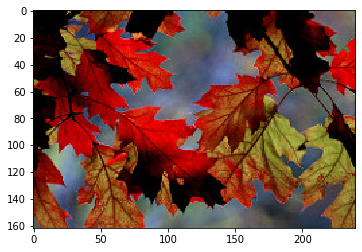

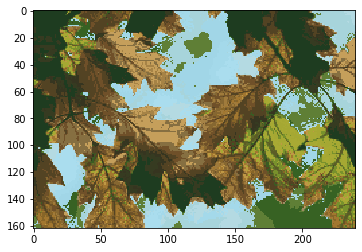

In [18]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(torch.from_numpy(T_dual), cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Dual with Entropy Regularizer", img/255, dataformats='HWC')

In [19]:
alpha, history = solve_semi_dual(a_1, b_1, C.numpy(), regul, max_iter=10000)
if enable_tensorboard:
    split_up_semi_dual_history_entropy(history, a, b, regul)
T_semi = get_plan_from_semi_dual(alpha, b.numpy(), C.numpy(), regul)
print(T_semi)
print("Semi-dual")
print("Value:", np.sum(T_semi * C.numpy()) + regul.Omega(T_semi))
print("loss: ", np.sum(T_semi * C.numpy()))
print("deviate from mass a: ", np.linalg.norm(np.matmul(T_semi, np.ones(b.size())) - a.numpy(), 2))
print("deviate from mass b: ", np.linalg.norm(np.matmul(np.transpose(T_semi), np.ones(a.size())) - b.numpy(), 2))
print("Sparsity:", np.sum(T_semi != 0) / T_semi.size)
print("objective function from Block Frank Wolfe: \n", (np.sum(T_semi * C.numpy())
      + np.linalg.norm(np.matmul(T_semi, np.ones(b.size())) - a.numpy(), 2)))

[[5.29376714e-30 8.29869773e-33 2.27199623e-41 ... 2.56922801e-41
  1.02261228e-81 1.48667497e-45]
 [6.27189433e-23 4.40614382e-25 1.17470659e-34 ... 7.92453414e-36
  1.01918018e-81 3.36235951e-38]
 [1.72851271e-02 9.58829603e-05 1.06026480e-09 ... 7.55617819e-08
  7.64514135e-50 6.34973879e-15]
 ...
 [5.84857396e-12 7.21475969e-03 2.15112086e-03 ... 1.24589787e-07
  3.17559430e-05 1.87008683e-02]
 [6.03293802e-18 3.81261823e-10 3.46519850e-11 ... 1.63377346e-14
  1.57398890e-13 7.79384901e-11]
 [1.08718802e-09 2.30344617e-03 7.34067394e-04 ... 8.40228428e-06
  3.22397054e-05 1.78813071e-05]]
Semi-dual
Value: 87.68833140363432
loss:  91.9177363121567
deviate from mass a:  0.052520145665018406
deviate from mass b:  4.446445162750826e-17
Sparsity: 1.0
objective function from Block Frank Wolfe: 
 91.97025645782172


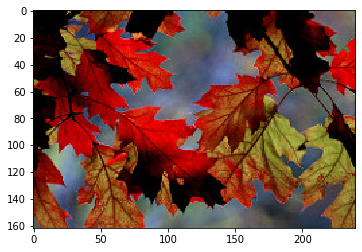

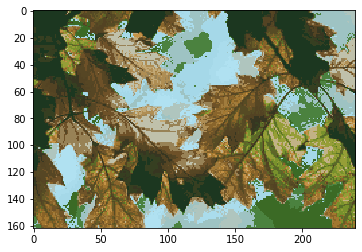

In [20]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(torch.from_numpy(T_semi), cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Semi Dual with Entropy Regularizer", img/255, dataformats='HWC')

### Apply Squared L2 Regularizer:

### dual with relaxed penality:

In [21]:
regul = SquaredL2(gamma=1)
alpha, beta, history = solve_dual(a_1, b_1, C.numpy(), regul, max_iter=10000)
if enable_tensorboard:
    split_up_dual_history_L2_regularizer(history, a, b, regul)
T_dual = get_plan_from_dual(alpha, beta, C.numpy(), regul)
print(T_dual)
print("Dual")
print("Value:", np.sum(T_dual * C.numpy()) + regul.Omega(T_dual))
print("loss: ", np.sum(T_dual * C.numpy()))
print("deviate from mass a: ", np.linalg.norm(np.matmul(T_dual, np.ones(b.size())) - a.numpy(), 2))
print("deviate from mass b: ", np.linalg.norm(np.matmul(np.transpose(T_dual), np.ones(a.size())) - b.numpy(), 2))
print("Sparsity:", np.sum(T_dual != 0) / T_dual.size)
print("objective function from Block Frank Wolfe: \n", (np.sum(T_dual * C.numpy())
      + np.linalg.norm(np.matmul(T_dual, np.ones(b.size())) - a.numpy(), 2)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Dual
Value: 91.99178088028448
loss:  91.84463592290948
deviate from mass a:  0.49405750764800543
deviate from mass b:  0.48909073941806297
Sparsity: 0.005859375
objective function from Block Frank Wolfe: 
 92.33869343055748


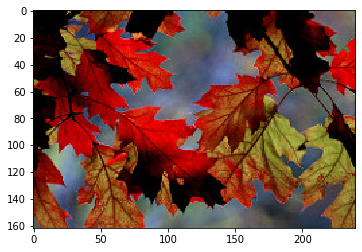

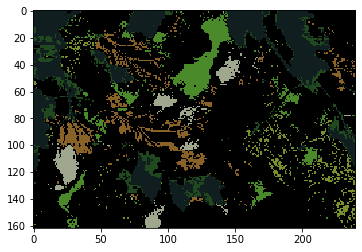

In [22]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(torch.from_numpy(T_dual), cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Dual with L2 Regularizer", img/255, dataformats='HWC')

### dual with semi relaxed penality:

In [23]:
alpha, history = solve_semi_dual(a_1, b_1, C.numpy(), regul, max_iter=10000)
if enable_tensorboard:
    split_up_semi_dual_history_L2_regularizer(history, a, b, regul)
T_semi = get_plan_from_semi_dual(alpha, b_1, C.numpy(), regul)
print(T_semi)
print("Semi-dual")
print("Value: ", np.sum(T_semi * C.numpy()) + regul.Omega(T_semi))
print("loss: ", np.sum(T_semi * C.numpy()))
print("deviate from mass a: ", np.linalg.norm(np.matmul(T_semi, np.ones(b.size())) - a.numpy(), 2))
print("deviate from mass b: ", np.linalg.norm(np.matmul(np.transpose(T_semi), np.ones(a.size())) - b.numpy(), 2))
print("Sparsity:", np.sum(T_semi != 0) / T_semi.size)
print("objective function from Block Frank Wolfe: \n", (np.sum(T_semi * C.numpy())
      + np.linalg.norm(np.matmul(T_semi, np.ones(b.size())) - a.numpy(), 2)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Semi-dual
Value:  94.04775178842291
loss:  94.02422309959769
deviate from mass a:  0.19780564230802203
deviate from mass b:  0.0
Sparsity: 0.03125
objective function from Block Frank Wolfe: 
 94.22202874190572


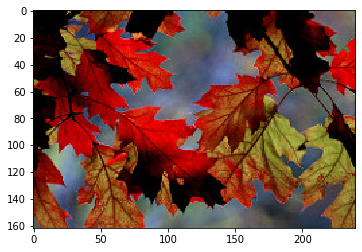

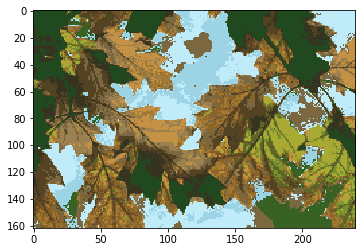

In [24]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(torch.from_numpy(T_semi), cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Semi Dual with L2 regularizer", img/255, dataformats='HWC')

## Apply Block Frank Wolfe on Semi Relaxed Primal:

In [25]:
def BlockFrankWolfe(var, grad, a, b, gamma):
    '''
        In this implementation, we use vector b as the hard penality.
        I.e. the sum of col j in var must be equal to the value of b_j.
        Also, each entry of var must be greater or equal to 0.
        
        Therefore, the exterme point is only the points, with one entry as b_j and
        all other entry is zero. And another extreme point is entry of all zero.
        
        And vector b has shape of n * 1, which is the second dimension
        size of tensor var.
        
        args:
        var: variable needs to be updated and it has shape of m * n.
        grad: gradient with respect to the input variable, with shape of m * n.
        a: soft constraint with size of m, which is the first dimension
        size of tensor var.
        b: hard penallity with size of n, which is the second dimension
        size of tensor var.
        gamma: linear combination coefficient or stepsize.
    '''
    #pdb.set_trace()
    rand_dim = torch.randint(0, b.size()[0], (1,)).item()
    grad_min_indice = torch.argmin(grad[:, rand_dim])
    var_update = var.clone()
    w = torch.zeros(var.size()[0])
    w[grad_min_indice] = b[rand_dim]
    #pdb.set_trace()
    var_update[:, rand_dim] = (1- gamma) * var[:, rand_dim] + gamma * w
    return var_update

In [26]:
def objective_function(T, a, b, C, p=2):
    vector_one = torch.ones(b.size())
    obj = torch.sum(T.double() * C.double()).double() + torch.norm(torch.matmul(T.double(), vector_one.double()) - a.double(), p)
    return obj

def get_gradient(var, a, b, C, p=2):
    var.requires_grad_(True)
    obj = objective_function(var, a, b, C, p = 2)
    #obj.zero_grad()
    obj.backward()
    return var.grad

def draw_tensorboard_blockFW(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/Block Frank Wolfe', cost, k)
    writer.add_scalar('objective value/Block Frank Wolfe', value, k)
    writer.add_scalar('deviate from a/Block Frank Wolfe', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/Block Frank Wolfe', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/Block Frank Wolfe', get_sparsity(T), k)
    
def minimize_block(var, a, b, C, epoch, gamma=0.8, p=2, threshold = 10 ** (-7)):
    iteration_counter = 0
    total_time = 0
    # large step size part
    for k in range(epoch):
        iteration_counter += 1
        start = time.time()
        grad = get_gradient(var, a, b, C, p)
        var.requires_grad_(False)
        new_var = BlockFrankWolfe(var, grad, a, b, gamma)
        if enable_tensorboard:
            draw_tensorboard_blockFW(get_transfer_cost(var, C), objective_function(var, a, b, C, p), var, a, b, k)
        end = time.time()
        total_time += (end - start)
        if (new_var - var).abs().sum() < threshold:
            return var, iteration_counter, total_time
        var = new_var
    
    # adaptive step size part
    for k in range(epoch):
        iteration_counter += 1
        start = time.time()
        gamma = 2 * b.size()[0] /(k + 2 * b.size()[0])
        grad = get_gradient(var, a, b, C, p)
        var.requires_grad_(False)
        if enable_tensorboard:
            draw_tensorboard_blockFW(get_transfer_cost(var, C), objective_function(var, a, b, C, p), var, a, b, k+epoch)
        new_var = BlockFrankWolfe(var, grad, a, b, gamma)
        end = time.time()
        total_time += (end - start)
        if (new_var - var).abs().sum() < threshold:
            return var, iteration_counter, total_time
        var = new_var
    return var, iteration_counter, total_time

In [27]:
# initial for T_block
# set first dimension of T to be b and all other entry be 0, then T is guaranteed to be feasible
T_block = torch.zeros([a.size()[0], b.size()[0]])
T_block[0, :] = b

In [28]:
T_block, iteration_counter, total_time = minimize_block(T_block, a, b, C, epoch=10000, p=2, threshold = 10 ** (-8))

In [29]:
print("Block Frank Wolfe:")
print(T_block)
print("objective function from Block Frank Wolfe: \n ", (torch.sum(T_block.double() * C.double()).item() 
      + torch.norm(torch.matmul(T_block.double(),torch.ones(b.size()).double()) - a.double(), 2)).item())
print("tranfer cost: ", torch.sum(T_block.double() * C.double()).item())
print("deviate from mass a: ", get_deviate_a(T_block, a, b))
print("deviate from mass b: ", get_deviate_b(T_block, a, b))
print("Sparsity:", torch.sum( T_block[:,:] != 0).item() / (T_block.size()[0] * T_block.size()[1]))
print("Average time: ", total_time / iteration_counter)

Block Frank Wolfe:
tensor([[7.9095e-06, 1.3588e-05, 6.6358e-04,  ..., 1.5621e-06, 3.5226e-06,
         2.1745e-06],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.4709e-02, 4.2450e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
objective function from Block Frank Wolfe: 
  53.19440559918325
tranfer cost:  52.91737950975782
deviate from mass a:  0.2770260894254235
deviate from mass b:  7.813119476942964e-09
Sparsity: 0.0615234375
Average time:  0.0015240626202689277


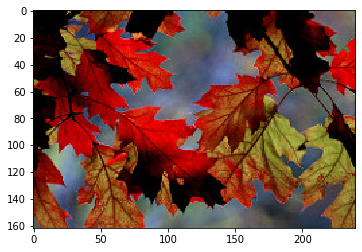

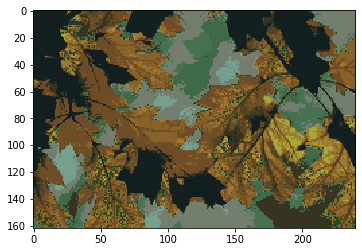

In [30]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(T_block, cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Block Frank Wolfe", img/255, dataformats='HWC')

## Apply Frank Wolfe on Semi Relaxed primal:

In [31]:
def FrankWolfe(var, grad, a, b, gamma):
    '''
        In this implementation, we use vector b as the hard penality.
        I.e. the sum of col j in var must be equal to the value of b_j.
        Also, each entry of var must be greater or equal to 0.
        
        Therefore, the exterme point is only the points, with one entry as b_j and
        all other entry is zero. And another extreme point is entry of all zero.
        
        And vector b has shape of n * 1, which is the second dimension
        size of tensor var.
        
        args:
        var: variable needs to be updated and it has shape of m * n.
        grad: gradient with respect to the input variable, with shape of m * n.
        a: soft constraint with size of m, which is the first dimension
        size of tensor var.
        b: hard penallity with size of n, which is the second dimension
        size of tensor var.
        gamma: linear combination coefficient or stepsize.
    '''
    grad_min_indice = grad.argmin(0)
    var_update = var.clone()
    w = torch.zeros(var.size())
    for i in range(grad_min_indice.size()[0]):
        w[grad_min_indice[i]][i] = b[i]
    var_update = (1- gamma) * var + gamma * w
    return var_update

In [32]:
def draw_tensorboard_FW(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/Frank Wolfe', cost, k)
    writer.add_scalar('objective value/Frank Wolfe', value, k)
    writer.add_scalar('deviate from a/Frank Wolfe', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/Frank Wolfe', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/Frank Wolfe', get_sparsity(T), k)

In [33]:
def minimize_fw(var, a, b, C, epoch, gamma=0.8, p=2, threshold = 10 ** (-7)):
    iteration_counter = 0
    total_time = 0
    # large step size part
    for k in range(epoch):
        start = time.time()
        iteration_counter += 1
        grad = get_gradient(var, a, b, C, p)
        var.requires_grad_(False)
        new_var = FrankWolfe(var, grad, a, b, gamma)
        if enable_tensorboard:
            draw_tensorboard_FW(get_transfer_cost(var, C), objective_function(var, a, b, C, p), var, a, b, k)
        end = time.time()
        total_time += end - start
        if (new_var - var).abs().sum() < threshold:
            return var, iteration_counter, total_time
        var = new_var
    
    # adaptive step size part
    for k in range(epoch):
        start = time.time()
        iteration_counter += 1
        gamma = 2 * b.size()[0] /(k + 2 * b.size()[0])
        grad = get_gradient(var, a, b, C, p)
        var.requires_grad_(False)
        new_var = FrankWolfe(var, grad, a, b, gamma)
        if enable_tensorboard:
            draw_tensorboard_FW(get_transfer_cost(var, C), objective_function(var, a, b, C, p), var, a, b, k+epoch)
        end = time.time()
        total_time += (end - start)
        if (new_var - var).abs().sum() < threshold:
            return var, iteration_counter, total_time
        var = new_var
    return var, iteration_counter, total_time

In [34]:
# initial for T_block
# set first dimension of T to be b and all other entry be 0, then T is guaranteed to be feasible
T_fw = torch.zeros([a.size()[0], b.size()[0]])
T_fw[0, :] = b

In [35]:
T_fw, iteration_counter, total_time = minimize_fw(T_fw, a, b, C, epoch=1000, p=2)

In [36]:
print("Frank Wolfe:")
print(T_fw)
print("objective function from Block Frank Wolfe: \n ", (torch.sum(T_fw.double() * C.double()).item() 
      + torch.norm(torch.matmul(T_fw.double(),torch.ones(b.size()).double()) - a.double(), 2)).item())
print("transfer cost: ", torch.sum(T_fw.double() * C.double()).item())
print("deviate from mass a: ", get_deviate_a(T_fw, a, b))
print("deviate from mass b: ", get_deviate_b(T_fw, a, b))
print("Sparsity:", torch.sum( T_fw[:,:] != 0).item() / (T_fw.size()[0] * T_fw.size()[1]))
print("Average running time per iteration: ", total_time / iteration_counter)

Frank Wolfe:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0247, 0.0425, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
objective function from Block Frank Wolfe: 
  48.46333941063103
transfer cost:  48.176222337374696
deviate from mass a:  0.2871170732563305
deviate from mass b:  1.5995990519707712e-08
Sparsity: 0.0322265625
Average running time per iteration:  0.003004283785820007


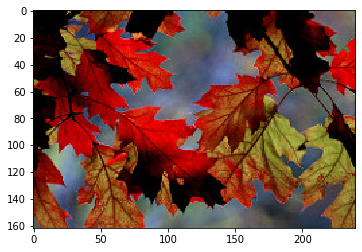

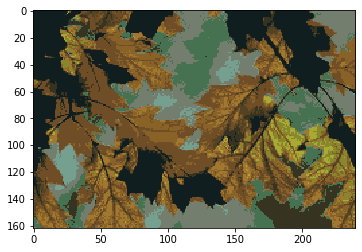

In [37]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(T_fw, cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Frank Wolfe", img/255, dataformats='HWC')

## Sinkhorn Algorithm:

In [38]:
def split_sinkhorn_history(a, b, C, history, reg):
    for k in range(len(history)):
        u_k = history['u'][k]
        v_k = history['v'][k]
        value = history['err'][k]
        
        # The reason for this K is from the reference of the code of "ot.sinkhorn_knopp", in the file "brgman.py",
        # which is used to combine with u and v to calculate T out.
        K = K = np.empty(C.numpy().shape, dtype=C.numpy().dtype)
        np.divide(C.numpy(), -reg, out=K)
        np.exp(K, out=K)
        T_sink_k = u_k.reshape((-1, 1)) * K * v_k.reshape((1, -1))
        
        cost = np.sum(T_sink_k * C.numpy())
        draw_tensorboard_sinkhorn(torch.tensor(cost), torch.tensor(value), 
                                                  torch.tensor(T_sink_k), a, b, k)

def draw_tensorboard_sinkhorn(cost, value, T, a, b, k):
    writer.add_scalar('transfer cost/Sinkhorn', cost, k)
    writer.add_scalar('objective value/Sinkhorn', value, k)
    writer.add_scalar('deviate from a/Sinkhorn', get_deviate_a(T, a, b), k)
    writer.add_scalar('deviate from b/Sinkhorn', get_deviate_b(T, a, b), k)
    writer.add_scalar('sparsity/Sinkhorn', get_sparsity(T), k)

In [39]:
reg = 1
T_sink, history = ot.sinkhorn(a.numpy(), b.numpy(), C.numpy(), reg = reg, log = True)
loss = ot.sinkhorn2(a.numpy(), b.numpy(), C.numpy(), reg = reg, log = False)
if enable_tensorboard:
    split_sinkhorn_history(a, b, C, history,reg)
print("T_sink: ",T_sink)
print("loss:", loss[0])
print("objective function from Block Frank Wolfe: \n", (np.sum(T_sink * C.numpy())
      + np.linalg.norm(np.matmul(T_sink, np.ones(b.size())) - a.numpy(), 2)))
print("deviate from mass a: ", np.linalg.norm(np.matmul(T_sink, np.ones(b.size())) - a.numpy(), 2))
print("deviate from mass b: ", np.linalg.norm(np.matmul(np.transpose(T_sink), np.ones(a.size())) - b.numpy(), 2))
print("Sparsity:", np.sum(T_semi != 0) / T_semi.size)

T_sink:  [[1.51322541e-30 6.74545259e-34 2.47639236e-42 ... 2.23341494e-42
  5.97064010e-82 8.11806625e-46]
 [3.24244193e-23 6.47730726e-26 2.31566609e-35 ... 1.24587706e-36
  1.07620633e-81 3.32059105e-38]
 [1.24786941e-02 1.96834105e-05 2.91866304e-10 ... 1.65892490e-08
  1.12733549e-49 8.75689596e-15]
 ...
 [7.36975285e-13 2.58515843e-04 1.03357217e-04 ... 4.77434014e-09
  8.17333031e-06 4.50155416e-03]
 [1.21610853e-15 2.18539099e-08 2.66345060e-09 ... 1.00152843e-12
  6.48061524e-11 3.00118820e-08]
 [8.80208044e-09 5.30299354e-03 2.26615528e-03 ... 2.06874052e-05
  5.33141929e-04 2.76552575e-04]]
loss: 90.93709889215279
objective function from Block Frank Wolfe: 
 90.93709889215295
deviate from mass a:  3.1176798565727256e-17
deviate from mass b:  1.918222489016651e-06
Sparsity: 0.03125


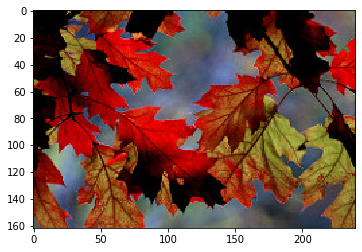

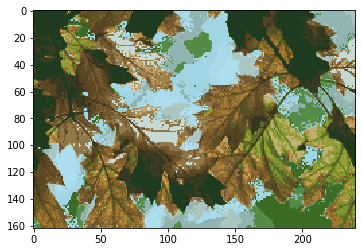

In [40]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(torch.from_numpy(T_sink), cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.numpy()/255)
if enable_tensorboard:
    writer.add_image("Tranferred Image/Sinkhorn", img/255, dataformats='HWC')

## Apply SGD:

In [41]:
# To make sure that all entry of T is greater than or equal to 0.
def projection(var):
    for i in range(var.size()[0]):
        for j in range(var.size()[1]):
            if var.data[i,j] < 0:
                var.data[i,j] = 0
            #if var.data[i,j] > 1:
            #    var.data[i,j] = 1
    return var

def objective_SGD(var, a, b, C, lambda_=1/2, p=2):
    vector_one_1 = torch.ones(b.size())
    vector_one_2 = torch.ones(a.size())
    obj = (torch.sum(var.double() * C.double()).double() 
        + lambda_ * torch.norm(torch.matmul(var.double(), vector_one_1.double()) - a.double(), p).double() 
        + lambda_ * torch.norm(torch.matmul(var.t().double(), vector_one_2.double()) - b.double(), p).double())
    return obj
    
    
def minimize_SGD(T, a, b, C, epoch, lr, lambda_=1/2, p=2, T_info=False):
    optimizer = torch.optim.SGD([T], lr=lr, momentum=0.9)
    for i in range(epoch):
        optimizer.zero_grad()
        loss = objective_SGD(T, a, b, C, lambda_= lambda_, p=2)
        loss.backward()
        optimizer.step()
        projection(T)
        print("epoch: ",i, ", loss: ",loss.item())
        if T_info:
            print("update of T:")
            print("min: ",T.min().item())
            print("max: ", T.max().item())

In [42]:
# initialize
T_SGD = torch.rand([a.size()[0], b.size()[0]])
T_SGD.requires_grad_(True)
print(T_SGD)

tensor([[0.4190, 0.9144, 0.7735,  ..., 0.4941, 0.3221, 0.9990],
        [0.3752, 0.9595, 0.2274,  ..., 0.7178, 0.3933, 0.5526],
        [0.7814, 0.4094, 0.0931,  ..., 0.8989, 0.5740, 0.5374],
        ...,
        [0.1152, 0.3877, 0.4420,  ..., 0.0061, 0.6614, 0.6017],
        [0.4811, 0.2537, 0.8886,  ..., 0.2206, 0.5089, 0.2260],
        [0.4087, 0.2138, 0.3736,  ..., 0.6787, 0.6705, 0.4925]],
       requires_grad=True)


In [43]:
lambda_ = 100
minimize_SGD(T_SGD, a, b, C, epoch=20, lr=0.1, lambda_=lambda_, p=2)

epoch:  0 , loss:  93910.7251395287
epoch:  1 , loss:  42.5116503361416
epoch:  2 , loss:  42.5116503361416
epoch:  3 , loss:  492.13980505765096
epoch:  4 , loss:  42.5116503361416
epoch:  5 , loss:  284.67223711698716
epoch:  6 , loss:  42.5116503361416
epoch:  7 , loss:  42.5116503361416
epoch:  8 , loss:  682.3550152111164
epoch:  9 , loss:  42.5116503361416
epoch:  10 , loss:  42.5116503361416
epoch:  11 , loss:  481.63437916138406
epoch:  12 , loss:  42.5116503361416
epoch:  13 , loss:  42.5116503361416
epoch:  14 , loss:  42.5116503361416
epoch:  15 , loss:  335.40340186178275
epoch:  16 , loss:  42.5116503361416
epoch:  17 , loss:  113.80653505659568
epoch:  18 , loss:  42.5116503361416
epoch:  19 , loss:  831.9144732299592


In [44]:
T_SGD.requires_grad_(False)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [45]:
print("SGD:")
print(T_SGD)
print("min: ",T_SGD.min().item())
print("max: ",T_SGD.max().item())
print("objective function from Block Frank Wolfe: \n ", (torch.sum(T_SGD.double() * C.double()).item() 
      + torch.norm(torch.matmul(T_fw.double(),torch.ones(b.size()).double()) - a.double(), 2)).item())
print("loss: ", objective_SGD(T_SGD, a, b, C, lambda_).item())
print("deviate from mass a: ", torch.norm(torch.matmul(T_SGD.double(), torch.ones(b.size()).double()) - a.double(), 2).item())
print("deviate from mass b: ", torch.norm(torch.matmul(T_SGD.t().double(),torch.ones(a.size()).double()) - b.double(), 2).item())
print("Sparsity:", torch.sum( T_SGD[:,:] != 0).item() / (T_SGD.size()[0] * T_SGD.size()[1]))

SGD:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
min:  0.0
max:  0.0
objective function from Block Frank Wolfe: 
  0.2871170732563305
loss:  42.5116503361416
deviate from mass a:  0.2081893781546878
deviate from mass b:  0.21692712520672816
Sparsity: 0.0


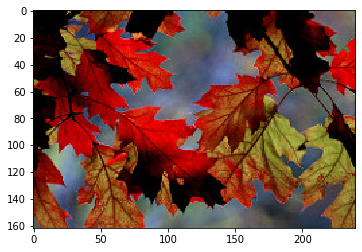

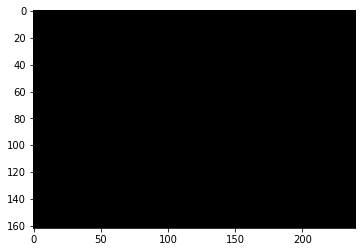

In [46]:
img = load_image(target)
f1 = plt.figure()
plt.imshow(img)
img = get_updated_img_tensor(T_SGD, cluster_center_source, cluster_center_target)
f2 = plt.figure()
plt.imshow(img.detach().numpy()/255)